<a href="https://colab.research.google.com/github/vkjadon/tf-CNN/blob/main/tf116introCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Implementing Padding

Let us write a function to implementing padding using `numpy` pad method. Padding helps maintain spatial dimensions and prevents information loss along the edges of the data. The `numpy.pad()` function takes several arguments, including the array to pad, the padding sizes for each dimension, and the mode of padding (constant, edge, wrap, etc.).

The general syntax of the `numpy.pad()` function:

```
numpy.pad(array, pad_width, mode)
```
Suppose you have a grayscale image represented as a 2D NumPy array and you want to apply padding to it before performing a convolution operation. Here's how you can use `numpy.pad()`:



In [ ]:
image = np.arange(1,26).reshape(5,5)

# Add zero-padding of size 1 to all sides
padded_image = np.pad(image, pad_width=1, mode='constant')

print("Original Image:")
print(image)

print("\nPadded Image:")
print(padded_image)

In this example, the `numpy.pad()` function adds a border of zeros (constant value padding) around the original 5x5 grayscale image. The padding size is specified as `pad_width=1` for all sides. The resulting padded image has a size of 7x7.

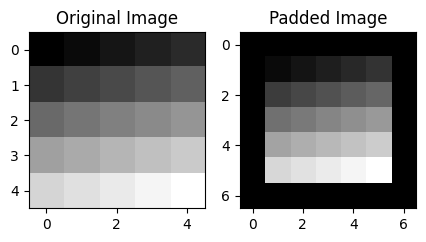

In [30]:
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('Original Image')
axarr[0].imshow(image)
axarr[1].set_title('Padded Image')
axarr[1].imshow(padded_image)


The above code pads the image with zeros and evident from image in right. The padding is applied to the height and width of an image.

In some of the operation we, need to give padding of different size to hight and width. In such cases, it is convinient to develop a custom function to deploy the padding.

The function should take a batch of the images and array of pad for each dimension of the image. The shape of the mage (m, n_H, n_W, n_C) represents a batch of m images with n_C channels and pad is an array of the padding to be applied to each of the dimension.
    
It is obvious that the function to return the padded images. The shape of the padded image would be *(m, n_H + 2 * pad, n_W + 2 * pad, n_C)*

In [27]:
def zero_pad(X, pad):

  X_pad = np.pad(X, pad, mode='constant', constant_values = (0,0))

  return X_pad

In [35]:
x = np.random.randint(1, 3, 3, 1)
pad=np.array([(0,0), (2,2), (2,2), (0,0)])
x_pad = zero_pad(x, pad)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1,1,0] =\n", x[0,1,1,0])
print ("x_pad[1,1] =\n", x_pad[0])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])

AttributeError: ignored

### Exercise 2 - conv_single_step
Implement `conv_single_step()`.

Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation of the previous layer.

Arguments:

- a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
- W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
- b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

Returns:

- Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data

In [ ]:
def conv_single_step(a_slice_prev, W, b):

    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    b=b[0][0][0].astype(np.float64)

    # Sum over all entries of the volume s.
    s = np.multiply(a_slice_prev, W)

    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = np.sum(s)+b
    #print(b)
    #print(type(Z))

    return Z

In [ ]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

assert (type(Z) == np.float64), "You must cast the output to numpy float 64"
assert np.isclose(Z, -6.999089450680221), "Wrong value"

Z = -6.999089450680221


### Exercise 3 -  conv_forward
Implement the function below to convolve the filters `W` on an input activation `A_prev`.  
This function takes the following inputs:
* `A_prev`, the activations output by the previous layer (for a batch of m inputs);
* Weights are denoted by `W`.  The filter window size is `f` by `f`.
* The bias vector is `b`, where each filter has its own (single) bias.

You also have access to the hyperparameters dictionary, which contains the stride and the padding.

**Hint**:
1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), you would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notice how this gives a 3D slice that has height 2, width 2, and depth 3.  Depth is the number of channels.  
This will be useful when you will define `a_slice_prev` below, using the `start/end` indexes you will define.

2. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find out how each of the corners can be defined using h, w, f and s in the code below.



**Reminder**:
    
The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$
    



For this exercise, don't worry about vectorization! Just implement everything with for-loops.

#### Additional Hints (if you're stuck):


* Use array slicing (e.g.`varname[0:1,:,3:5]`) for the following variables:  
  `a_prev_pad` ,`W`, `b`  
  - Copy the starter code of the function and run it outside of the defined function, in separate cells.  
  - Check that the subset of each array is the size and dimension that you're expecting.  
* To decide how to get the `vert_start`, `vert_end`, `horiz_start`, `horiz_end`, remember that these are indices of the previous layer.  
  - Draw an example of a previous padded layer (8 x 8, for instance), and the current (output layer) (2 x 2, for instance).  
  - The output layer's indices are denoted by `h` and `w`.  
* Make sure that `a_slice_prev` has a height, width and depth.
* Remember that `a_prev_pad` is a subset of `A_prev_pad`.  
  - Think about which one should be used within the for loops.

In [ ]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function

    Arguments:
    A_prev -- output activations of the previous layer,
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"

    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """

    # Retrieve dimensions from A_prev's shape (≈1 line)
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    print(m,n_H_prev, n_W_prev, n_C_prev)

    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    print(f,f, n_C_prev, n_C)

    # Retrieve information from "hparameters" (≈2 lines)
    pad=hparameters["pad"]
    stride=hparameters["stride"]
    print(pad,stride)

    # Compute the dimensions of the CONV output volume using the formula given above.
    # Hint: use int() to apply the 'floor' operation. (≈2 lines)
    n_H = int(((n_H_prev+2*pad-f)/stride)+1)
    n_W = int(((n_W_prev+2*pad-f)/stride)+1)
    print(n_H, n_W)

    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros([m,n_H,n_W,n_C])
    print(Z.shape)

    # Create A_prev_pad by padding A_prev
    print(A_prev.shape)
    A_prev_pad=zero_pad(A_prev, pad)
    print(A_prev_pad.shape)

    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]               # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h * stride
            vert_end = vert_start + f

            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                horiz_start = w * stride
                horiz_end = horiz_start + f

                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])

    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
cache_0_1_2_3 = cache_conv[0][1][2][3]
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)
print("cache_conv[0][1][2][3] =\n", cache_0_1_2_3)

2 5 7 4
3 3 4 8
1 2
3 4
(2, 3, 4, 8)
(2, 5, 7, 4)
(2, 7, 9, 4)
Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


Finally, a CONV layer should also contain an activation, in which case you would add the following line of code:

```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```

You don't need to do it here, however.


### Exercise 4 - pool_forward

Implement the forward pass of the pooling layer. Follow the hints in the comments below.

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$


In [ ]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer

    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")

    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters
    """

    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))

    # for i in range(None):                         # loop over the training examples
        # for h in range(None):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            # vert_start = None
            # vert_end = None

            # for w in range(None):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                # horiz_start = None
                # horiz_end = None

                # for c in range (None):            # loop over the channels of the output volume

                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    # a_prev_slice = None

                    # Compute the pooling operation on the slice.
                    # Use an if statement to differentiate the modes.
                    # Use np.max and np.mean.
                    # if mode == "max":
                        # A[i, h, w, c] = None
                    # elif mode == "average":
                        # A[i, h, w, c] = None

    # YOUR CODE STARTS HERE
    for i in range(m):
        for h in range(n_H):
            vert_start = h * stride
            vert_end = vert_start + f
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                for c in range(n_C):
                    a_prev_slice = A_prev[vert_start:vert_end, horiz_start:horiz_end, :]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)

    # YOUR CODE ENDS HERE

    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)

    # Making sure your output shape is correct
    #assert(A.shape == (m, n_H, n_W, n_C))

    return A, cache

In [ ]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

ValueError: ignored